# COVID-19 Transfer Learning

Training a model for flu and then repurposing it for COVID

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input

from covid_flu import config, utils, time_series, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
df_flu = utils.load_flu_data()

In [18]:
df_covid = utils.load_covid_data()
display(df_covid.head())
display(df_covid.tail())

,date,state,cases
0,2020-01-21,Alabama,0.0
1,2020-01-22,Alabama,0.0
2,2020-01-23,Alabama,0.0
3,2020-01-24,Alabama,0.0
4,2020-01-25,Alabama,0.0


,date,state,cases
5770,2020-04-30,Wyoming,415.0
5771,2020-05-01,Wyoming,420.0
5772,2020-05-02,Wyoming,429.0
5773,2020-05-03,Wyoming,435.0
5774,2020-05-04,Wyoming,444.0


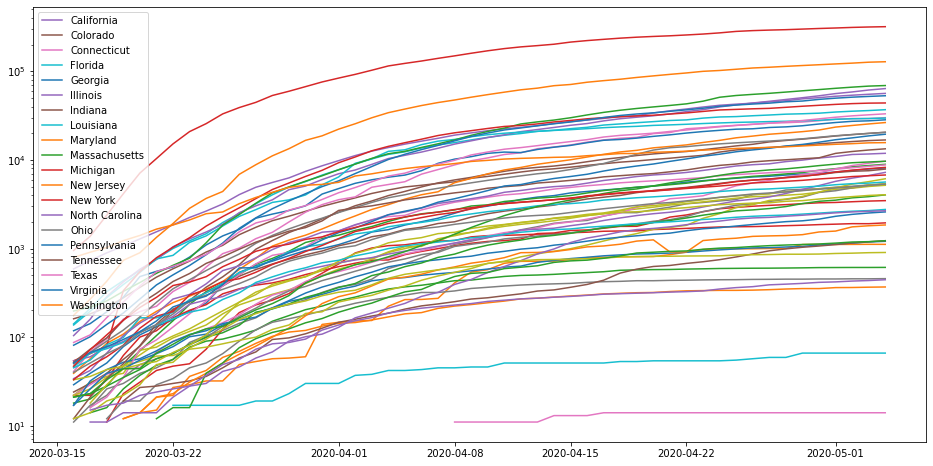

In [32]:
plt.figure(figsize=(16, 8))
plt.yscale('log')
for state in df_covid['state'].unique():
    subset = df_covid.query('state == @state').query('date > @pd.to_datetime("2020-03-15")').query('cases > 10')
    if (subset['cases'] > 10000).any():
        plt.plot(subset['date'], subset['cases'], label=state)
    else:
        plt.plot(subset['date'], subset['cases'])
plt.legend()
plt.show()

## Preparing data for COVID and flu

In [ ]:
HISTORY_SIZE = 10
TARGET_SIZE = 5
BATCH_SIZE = 64
TEST_SIZE = 0.3

# Scaling
df_flu['wili'] = utils.scale_data(df_flu['wili'].values)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values)

# Making train/val/test split
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE)

ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE3)

## Training the flu model